In [1]:
import os
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from collections import namedtuple, deque

In [2]:
# Function to render in notebook
def render_frame(env):
    frame = env.render()  # Returns the rendered frame as an RGB array
    plt.imshow(frame)
    plt.axis('off')  # Hide axis for better visualization
    clear_output(wait=True)  # Clear the previous frame
    plt.show()

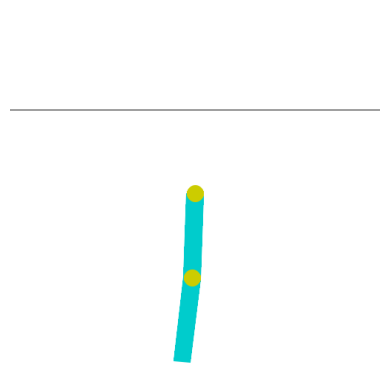

In [3]:
# Initialize the environment
env = gym.make("Acrobot-v1", render_mode="rgb_array")
state, info = env.reset()

render_frame(env)

### Goal 
- The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

### Observation Space
- The observation is a ndarray with shape (6,) of continuous variables
    - cos(theta1) [-1, 1]
    - sin(theta1) [-1, 1]
    - cos(theta2) [-1, 1]
    - sin(theta2) [-1, 1]
    - Angular velocity of theta1 (-4$\pi$, 4$\pi$)
    - Angular velocity of theta2 (-9$\pi$, 9$\pi$)

where: 
- theta1 is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly downwards.
- theta2 is relative to the angle of the first link. An angle of 0 corresponds to having the same angle between the two links.

### Action
- 3 possible discrete actions:
    - 0: apply -1 torque to the actuated joint (N/m)
    - 1: apply 0 torque to the actuated joint (N/m)
    - 2: apply +1 torque to the actuated joint (N/m)

### Reward
- -1 for each step

### End of episode
- The free end reaches the line or after 500 timesteps

In [4]:
env.observation_space

Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)

In [5]:
env.action_space

Discrete(3)

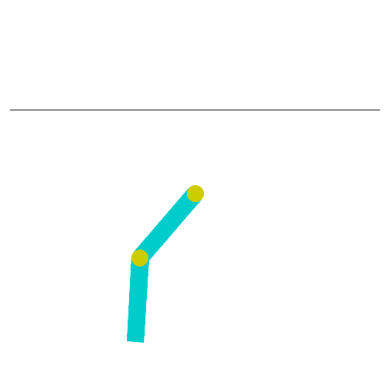

In [6]:
# visualize random policy

env = gym.make("Acrobot-v1", render_mode="rgb_array")
state, info = env.reset()

for _ in range(100):
    state, reward, done, _, info = env.step(env.action_space.sample())
    render_frame(env)

env.close()

## DQN Preliminaries

![qlearning](img/dqn.png)

### Replay buffer

In [7]:
Transition = namedtuple(
    'Transition',
    ('state', 'action', 'reward',  'done', 'next_state')
)

class ReplayMemory:

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        return Transition(*zip(*transitions))

    def __len__(self):
        return len(self.memory)

In [8]:
buffer = ReplayMemory(capacity=1000)

In [9]:
state, info = env.reset()
action = env.action_space.sample()
new_state, reward, done, terminated, info = env.step(action)
done = done or terminated

In [13]:
transition = Transition(state, action, reward, done, new_state)
buffer.push(transition)

In [14]:
batch = buffer.sample(3)
batch

Transition(state=(array([ 0.99945295, -0.03307194,  0.99994385,  0.010598  , -0.07205378,
       -0.0526349 ], dtype=float32), array([ 0.99945295, -0.03307194,  0.99994385,  0.010598  , -0.07205378,
       -0.0526349 ], dtype=float32), array([ 0.99945295, -0.03307194,  0.99994385,  0.010598  , -0.07205378,
       -0.0526349 ], dtype=float32)), action=(2, 2, 2), reward=(-1.0, -1.0, -1.0), done=(False, False, False), next_state=(array([ 0.99843174, -0.05598251,  0.999546  ,  0.03013046, -0.15188386,
        0.24079542], dtype=float32), array([ 0.99843174, -0.05598251,  0.999546  ,  0.03013046, -0.15188386,
        0.24079542], dtype=float32), array([ 0.99843174, -0.05598251,  0.999546  ,  0.03013046, -0.15188386,
        0.24079542], dtype=float32)))

### Q-Value Aproximation using a Neural Network

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):

    def __init__(self, obs_size, num_actions):
        super(QNetwork, self).__init__()
        self.layer1 = nn.Linear(obs_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.q = nn.Linear(32, num_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        q = self.q(x)
        return q

In [23]:
obs_size = env.observation_space.shape[0] # 6
num_actions = env.action_space.n # 3
qnetwork = QNetwork(obs_size, num_actions)
qnetwork

QNetwork(
  (layer1): Linear(in_features=6, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (q): Linear(in_features=32, out_features=3, bias=True)
)

In [24]:
state, info = env.reset()

# transform into tensor
state = torch.tensor(state)
qvals = qnetwork(state)
qvals 

tensor([ 0.1331, -0.1343,  0.3073], grad_fn=<ViewBackward0>)

In [25]:
batch_state = torch.tensor(np.vstack(batch.state))
batch_state

tensor([[ 0.9995, -0.0331,  0.9999,  0.0106, -0.0721, -0.0526],
        [ 0.9995, -0.0331,  0.9999,  0.0106, -0.0721, -0.0526],
        [ 0.9995, -0.0331,  0.9999,  0.0106, -0.0721, -0.0526]])

In [26]:
qvals = qnetwork(batch_state)
qvals

tensor([[ 0.1344, -0.1317,  0.3077],
        [ 0.1344, -0.1317,  0.3077],
        [ 0.1344, -0.1317,  0.3077]], grad_fn=<AddmmBackward0>)

In [27]:
qvals.shape

torch.Size([3, 3])

In [28]:
qvals.max(axis=1, keepdim=True)

torch.return_types.max(
values=tensor([[0.3077],
        [0.3077],
        [0.3077]], grad_fn=<MaxBackward0>),
indices=tensor([[2],
        [2],
        [2]]))

In [29]:
def get_eps(episode, min_eps=0.01, decay_fraction=0.1, total_episodes=15000):
    return max(min_eps, episode*(min_eps-1)/(total_episodes*decay_fraction)+1)

In [31]:
def dqn(
    env,
    gamma=0.995,
    min_eps=0.01,
    eps_decay_fraction=0.1,
    learning_rate=0.001,
    num_episodes=2000,
    batch_size=64,
    buffer_size=100000,
    steps_update_qnetwork=4,
    episodes_update_target=10,
):

    # init network and optimizer
    obs_size = env.observation_space.shape[0] # 6
    num_actions = env.action_space.n # 3
    qnetwork = QNetwork(obs_size, num_actions)
    target_qnetwork = QNetwork(obs_size, num_actions)
    optimizer = torch.optim.Adam(qnetwork.parameters(), lr=learning_rate)
    
    # track the episode returns
    step = 0
    returns = []
    for episode in range(1, num_episodes+1):
        
        episode_return = 0
        state, info = env.reset()
        done = False
    
        while not done:

            eps = get_eps(episode, min_eps=min_eps, decay_fraction=eps_decay_fraction, total_episodes=num_episodes)
            
            if np.random.random() > eps:
                # no gradient here
                with torch.no_grad():
                    # Get action from Q network
                    q = qnetwork(torch.tensor(state))
                    action = np.argmax(q)
            else:
                # Get random action
                action = env.action_space.sample()
    
            # apply the action to the environment
            new_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated 
            episode_return += reward

            # add to buffer
            if done:
                new_state = env.observation_space.sample() # dummy new state if done, otherwise is None
            buffer.push(Transition(state, action, reward, done, new_state))

            # update qnetwork
            if step%steps_update_qnetwork==0 and len(buffer)>=batch_size:

                batch = buffer.sample(batch_size)
                batch = Transition(*map(lambda x:torch.tensor(np.vstack(x), dtype=torch.float), batch)) # transform into tesor
                
                q_vals = qnetwork(batch.state)
                q_vals = q_vals.gather(1, batch.action.to(int)) # q values of chosen actions

                # compute the targets
                with torch.no_grad():
                    q_target = target_qnetwork(batch.next_state)
                    q_target = q_target.max(axis=1, keepdim=True).values # get the max of next state
                    targets = batch.reward+(1-batch.done)*gamma*q_target # next q_val only for non-ended episodes

                # MSE loss
                loss = F.mse_loss(q_vals, targets)

                # optimize
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(qnetwork.parameters(), max_norm=1.0)
                optimizer.step()

            state = new_state
            step += 1

        returns.append(episode_return)
        
        # update target network
        if episode%episodes_update_target==0:
            target_qnetwork.load_state_dict(qnetwork.state_dict())
    
        # log last 1000 episodes
        if episode % 100 == 0:
            print(f'Episode {episode}, returns: {np.mean(returns[-100:])}')

    return qnetwork, returns

In [32]:
%%time
qnetwork, returns = dqn(env)

Episode 100, returns: -482.99
Episode 200, returns: -280.09
Episode 300, returns: -291.24
Episode 400, returns: -162.05
Episode 500, returns: -185.55
Episode 600, returns: -99.04
Episode 700, returns: -117.35
Episode 800, returns: -138.94
Episode 900, returns: -107.32
Episode 1000, returns: -88.63
Episode 1100, returns: -88.8
Episode 1200, returns: -88.43
Episode 1300, returns: -84.0
Episode 1400, returns: -85.73
Episode 1500, returns: -93.51
Episode 1600, returns: -89.79
Episode 1700, returns: -100.4
Episode 1800, returns: -96.99
Episode 1900, returns: -89.09
Episode 2000, returns: -89.58
CPU times: user 9min 36s, sys: 1min 54s, total: 11min 30s
Wall time: 1min 32s


Text(0, 0.5, 'Returns')

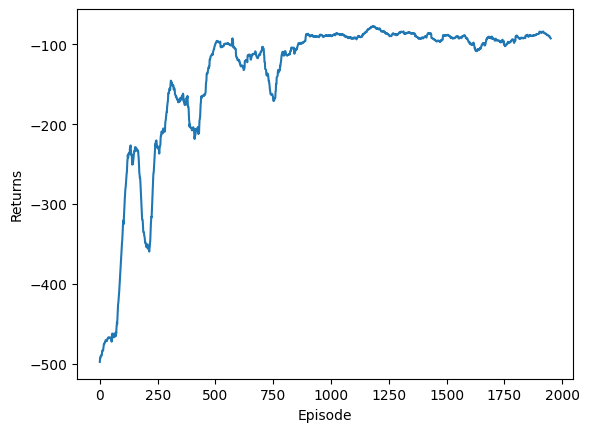

In [33]:
def running_mean(x, N=50):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(returns))
plt.xlabel('Episode')
plt.ylabel('Returns')

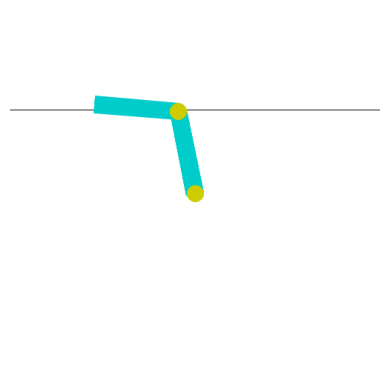

-108.0


In [35]:
state, info = env.reset()
render_frame(env)
done = False

r = 0
while not done:

    with torch.no_grad():
        # Get action from Q network
        q = qnetwork(torch.tensor(state))
        action = np.argmax(q)

    state, reward, done, truncated, _ = env.step(action)
    done = done or truncated
    render_frame(env)
    r += reward

print(r)